<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#models.segmentation.fcn_resnet50" data-toc-modified-id="models.segmentation.fcn_resnet50-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>models.segmentation.fcn_resnet50</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span><ul class="toc-item"><li><span><a href="#plot_examples()-시각화-함수-정의" data-toc-modified-id="plot_examples()-시각화-함수-정의-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span><code>plot_examples()</code> 시각화 함수 정의</a></span><ul class="toc-item"><li><span><a href="#train-set-시각화" data-toc-modified-id="train-set-시각화-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>train set 시각화</a></span></li><li><span><a href="#validation-set-시각화" data-toc-modified-id="validation-set-시각화-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>validation set 시각화</a></span></li><li><span><a href="#test-set-시각화" data-toc-modified-id="test-set-시각화-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>test set 시각화</a></span></li></ul></li></ul></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li></ul></div>

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 16   # Mini-batch size
num_epochs = 100
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


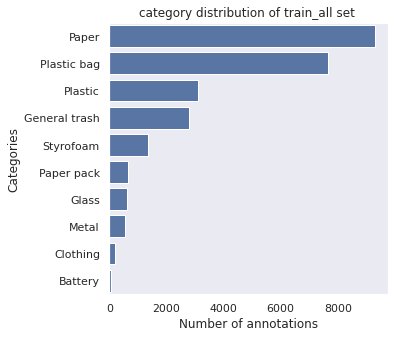

In [6]:
%matplotlib inline

dataset_path  = '../data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [7]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [9]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

## baseline model

### models.segmentation.fcn_resnet50

In [10]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models



### `plot_examples()` 시각화 함수 정의

In [16]:
import cv2
import os


def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloader=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    try:
        if not os.path.exists('/opt/ml/input/data/train'):
            os.makedirs('/opt/ml/input/data/' + 'train')
        if not os.path.exists('/opt/ml/input/data/val'):
            os.makedirs('/opt/ml/input/data/' + 'val')
    except:
        print('폴더 있음')
    # test / validation set에 대한 시각화
    for mode in ('test', 'val'):
        if mode == 'test':
            dataloader = train_loader
        if mode == 'val':
            dataloader = val_loader 
        #if mode == 'train_all': # 여기에 train_all loader를 불러와서 train_test_split 을 쓰면 랜덤으로 스플릿 할수 있습니다. 혹시 원하시면 추가 바랍니다.
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloader):
                    
                image_infos = image_infos
                temp_images = imgs
                temp_masks = masks

             
                for i in range(16): # 배치사이즈가 16이라 이렇게 했습니다.
                    try: print(image_infos[i]['file_name'])
                    except: continue # 마지막 batchsize에서 오류가 나서 그냥 exception했습니다.
                    img = label_to_color_image(masks[i].detach().cpu().numpy())
                    print(image_infos[i]['file_name'].split('/')[1])
                    if mode == 'test':
                        cv2.imwrite("/opt/ml/input/data/train/" + image_infos[i]['file_name'].split('/')[1], img)
                    elif mode == 'val':
                        cv2.imwrite("/opt/ml/input/data/val/" + image_infos[i]['file_name'].split('/')[1], img)
                        


#### train set 시각화

In [17]:
plot_examples(mode="train", batch_id=7, num_examples=batch_size, dataloader=train_loader)

batch_02_vt/1862.jpg
1862.jpg
batch_02_vt/0656.jpg
0656.jpg
batch_02_vt/0215.jpg
0215.jpg
batch_02_vt/1071.jpg
1071.jpg
batch_01_vt/0735.jpg
0735.jpg
batch_02_vt/1598.jpg
1598.jpg
batch_01_vt/0507.jpg
0507.jpg
batch_01_vt/1218.jpg
1218.jpg
batch_02_vt/0579.jpg
0579.jpg
batch_03/0814.jpg
0814.jpg
batch_03/0828.jpg
0828.jpg
batch_03/0894.jpg
0894.jpg
batch_02_vt/1781.jpg
1781.jpg
batch_03/0130.jpg
0130.jpg
batch_01_vt/0433.jpg
0433.jpg
batch_02_vt/0885.jpg
0885.jpg
batch_01_vt/0802.jpg
0802.jpg
batch_02_vt/1763.jpg
1763.jpg
batch_03/0361.jpg
0361.jpg
batch_02_vt/0801.jpg
0801.jpg
batch_02_vt/0940.jpg
0940.jpg
batch_02_vt/0996.jpg
0996.jpg
batch_03/0910.jpg
0910.jpg
batch_03/0321.jpg
0321.jpg
batch_01_vt/0598.jpg
0598.jpg
batch_02_vt/1750.jpg
1750.jpg
batch_02_vt/0421.jpg
0421.jpg
batch_02_vt/0101.jpg
0101.jpg
batch_03/0297.jpg
0297.jpg
batch_01_vt/0007.jpg
0007.jpg
batch_02_vt/0323.jpg
0323.jpg
batch_01_vt/0267.jpg
0267.jpg
batch_02_vt/1930.jpg
1930.jpg
batch_01_vt/0605.jpg
0605.jpg
batc